In [1]:
#!/usr/bin/env python
# coding: utf-8
from __future__ import print_function
import pandas as pd
from nltk.tokenize import regexp_tokenize
from gensim.models import KeyedVectors
from gensim.models import word2vec
from gensim.scripts import glove2word2vec
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(224)

##########################################
#Importing wiki vector####################
##########################################
## Mac
# = KeyedVectors.load_word2vec_format('/Users/marcowang/Downloads/text_project/data/word2vec_pretrain_data/wiki-news-300d-1M.vec')

# Ubantu
wiki_en = KeyedVectors.load_word2vec_format('/home/marco/Downloads/wiki-news-300d-1M.vec')

print('=' * 80)
print('Loading Success ！！')
print('=' * 80)

vocab_wiki = list(wiki_en.vocab.keys())
len(vocab_wiki) ### pretrain vocab 



Loading Success ！！


999994

In [2]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.vocab.keys())
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin
google = load_word2vec()

Loaded vocab size 3000000


## For GPU

In [3]:
USE_CUDA = torch.cuda.is_available()

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [4]:
    def getBatch(batch_size, train_data):
        random.shuffle(train_data)
        sindex = 0
        eindex = batch_size
        while eindex < len(train_data):
            batch = train_data[sindex: eindex]
            temp = eindex
            eindex = eindex + batch_size
            sindex = temp
            yield batch

        if eindex >= len(train_data):
            batch = train_data[sindex:]
            yield batch

In [5]:
random.seed(224)

In [6]:
def pad_to_batch(batch,max_x = 1024):
    x,y = zip(*batch)
    
    x_p = []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([word2index['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
    return torch.cat(x_p), torch.cat(y).view(-1)

In [7]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

In [19]:
#Mac
#news = pd.read_csv('/Users/marcowang/Dropbox/Textnews/TextProject/sample_data/news20190406_285.csv',index_col=None)

#Ubantu
news = pd.read_csv('/home/marco/Dropbox/Textnews/TextProject/sample_data/news20190406_285.csv',index_col=None)

newsText = list(news['NewsContent'])
flatten = lambda l:[item for sublist in  l for item in sublist]
newsToken = [regexp_tokenize(sent,pattern = '\w+|\$[\d\.]+|\S+') for sent in newsText] #####?
new_token = [x for x in newsToken if len(x)<=1000]
flatToken = flatten(new_token)
allWords = [w.lower() for w in flatToken]
vocabulary = list(set(allWords))  # news vocabulary 
len(vocabulary) ##   Oh my G~~~~， It is difficult for me to read about technical news~， so many words ~

9974

In [20]:
#Mac
#data = pd.read_csv('/Users/marcowang/Dropbox/Textnews/TextProject/sample_data/tagged_data/finalInput.csv',index_col=0)

#Ubantu
data = pd.read_csv('/home/marco/Dropbox/Textnews/TextProject/sample_data/tagged_data/finalInput.csv',index_col=0)


y_com = data.iloc[:,4:9].values # company info
y_sent = data.iloc[:,9:].values # 

# negative impact label as '2'
for i in range(y_sent.shape[0]):
    for j in range(y_sent.shape[1]):
        if y_sent[i][j] == -1:
            y_sent[i][j] = 2
        

In [21]:
word2index={'<PAD>': 0, '<UNK>': 1} # pad means padding !

for vo in vocabulary:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}



In [22]:
X_p, y_p = [],[]

for x,y in zip(newsToken,y_sent):
    if len(x) <=1000:
        X_p.append(prepare_sequence(x, word2index).view(1, -1))
        y_p.append(Variable(LongTensor(y)).view(1, -1))
        
    
data_p = list(zip(X_p,y_p))
random.shuffle(data_p)

train_data = data_p[: int(len(data_p) * 0.8)]
test_data = data_p[int(len(data_p) * 0.8):]
maxLength = max([x[0].size(1) for x in data_p])
print(maxLength)

985


## Getting the dataset for 5 companies

In [23]:
y_ap = [x[1][0][0].view(1, -1) for x in train_data ]
y_bm = [x[1][0][1].view(1, -1) for x in train_data ]
y_go = [x[1][0][2].view(1, -1) for x in train_data ]
y_am = [x[1][0][3].view(1, -1) for x in train_data ]
y_ms = [x[1][0][4].view(1, -1) for x in train_data ]
train_x = [x[0] for x in train_data ]
train_ap = list(zip(train_x,y_ap))
train_bm = list(zip(train_x,y_bm))
train_go = list(zip(train_x,y_go))
train_am = list(zip(train_x,y_am))
train_ms = list(zip(train_x,y_ms))

## pretrain vecter for all 

In [24]:
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(wiki_en[word2index[key]])
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

In [25]:
train_data[0][1]

tensor([[1, 2, 2, 0, 2]])

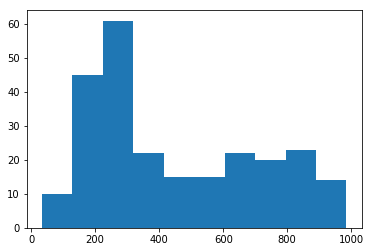

In [27]:
import matplotlib.pyplot as plt
plt.hist(xxx)
plt.show()

## training

### Model Artciteure

In [1]:
class Sent(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        super(Sent,self).__init__()
        self.embedding_w = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(     # LSTM 效果要比 nn.RNN() 好多了
        input_size = 300,      # vecter dimension
        hidden_size=64,     # rnn hidden unit
        num_layers=1,       # 
        batch_first=True,   # input & output 会是以 batch size 为第一维度的特征集 e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(64, 3) # 三分类  所以就用 3 
        
    
    
    def init_weights(self, pretrained_word_vectors, is_static=True):
        self.embedding_w.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding_w.weight.requires_grad = False


    def forward(self, inputs, is_training=False):
        inputs = self.embedding_w(inputs) # (B,1,T,D)
        r_out, (h_n, h_c) = self.rnn(inputs, None)
        out = self.out(r_out[:, -1, :])
        return out
           

NameError: name 'nn' is not defined

## Apple Model training 

In [29]:
EPOCH = 100
BATCH_SIZE = 20
LR = 0.001
TIME_STEP = 32          # rnn time step / image height
INPUT_SIZE = 32

apmodel = Sent(len(word2index), 300)
apmodel.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(apmodel.parameters(), lr=LR)

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_ap)):

        inputs,targets = pad_to_batch(batch)
        #print(targets.size())          
        apmodel.zero_grad()
        preds = apmodel(inputs,True)
        #print(preds.size())
        loss = loss_function(preds, targets)
        losses.append(loss.data.mean())
        loss.backward()
        
        
        optimizer.step()
        acc = 0
        if i % 100 == 0:
            for test in test_data:
                oup = apmodel(test[0])
                a = (torch.max(oup,1)[1].item())
                b = (test[1][0][0].item())
                if a == b:
                    acc +=1
            accuracy = acc/len(test_data)
            print('Epoch: ', str(epoch)+'/'+str(EPOCH), '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0/100 | train loss: 1.1145 | test accuracy: 0.44
Epoch:  1/100 | train loss: 1.0930 | test accuracy: 0.42
Epoch:  2/100 | train loss: 1.1168 | test accuracy: 0.42
Epoch:  3/100 | train loss: 1.2024 | test accuracy: 0.42
Epoch:  4/100 | train loss: 1.0287 | test accuracy: 0.42
Epoch:  5/100 | train loss: 0.9598 | test accuracy: 0.42
Epoch:  6/100 | train loss: 1.0213 | test accuracy: 0.42
Epoch:  7/100 | train loss: 1.1142 | test accuracy: 0.42
Epoch:  8/100 | train loss: 0.9803 | test accuracy: 0.42
Epoch:  9/100 | train loss: 0.9665 | test accuracy: 0.42
Epoch:  10/100 | train loss: 0.9749 | test accuracy: 0.42
Epoch:  11/100 | train loss: 1.0023 | test accuracy: 0.42
Epoch:  12/100 | train loss: 0.9143 | test accuracy: 0.42
Epoch:  13/100 | train loss: 0.9779 | test accuracy: 0.42
Epoch:  14/100 | train loss: 1.0143 | test accuracy: 0.42
Epoch:  15/100 | train loss: 1.0414 | test accuracy: 0.42
Epoch:  16/100 | train loss: 0.9846 | test accuracy: 0.42
Epoch:  17/100 | train l

### Ibm

In [36]:
EPOCH = 100
BATCH_SIZE = 50
LR = 0.001
TIME_STEP = 1024         # 
INPUT_SIZE = 1

bmmodel = Sent(len(word2index), 300)
bmmodel.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(bmmodel.parameters(), lr=LR)

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_bm)):

        inputs,targets = pad_to_batch(batch)
        #print(targets.size())          
        bmmodel.zero_grad()
        preds = bmmodel(inputs,True)
        #print(preds.size())
        loss = loss_function(preds, targets)
        losses.append(loss.data.mean())
        loss.backward()
        
        #for param in model.parameters():
        #    param.grad.data.clamp_(-3, 3)
        
        optimizer.step()
        acc = 0
        if i % 100 == 0:
            for test in test_data:
                oup = bmmodel(test[0])
                a = (torch.max(oup,1)[1].item())
                b = (test[1][0][0].item())
                if a == b:
                    acc +=1
            accuracy = acc/len(test_data)
            print('Epoch: ', str(epoch)+'/'+str(EPOCH), '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0/100 | train loss: 1.0515 | test accuracy: 0.36
Epoch:  1/100 | train loss: 1.0272 | test accuracy: 0.36
Epoch:  2/100 | train loss: 1.0457 | test accuracy: 0.36
Epoch:  3/100 | train loss: 1.0337 | test accuracy: 0.36
Epoch:  4/100 | train loss: 0.8722 | test accuracy: 0.34
Epoch:  5/100 | train loss: 0.9655 | test accuracy: 0.36
Epoch:  6/100 | train loss: 0.9119 | test accuracy: 0.36
Epoch:  7/100 | train loss: 0.9460 | test accuracy: 0.34
Epoch:  8/100 | train loss: 0.8320 | test accuracy: 0.34
Epoch:  9/100 | train loss: 1.1089 | test accuracy: 0.34
Epoch:  10/100 | train loss: 0.8906 | test accuracy: 0.34
Epoch:  11/100 | train loss: 0.9653 | test accuracy: 0.34
Epoch:  12/100 | train loss: 0.9131 | test accuracy: 0.34
Epoch:  13/100 | train loss: 0.9179 | test accuracy: 0.34
Epoch:  14/100 | train loss: 0.9329 | test accuracy: 0.34
Epoch:  15/100 | train loss: 0.9024 | test accuracy: 0.34
Epoch:  16/100 | train loss: 0.9596 | test accuracy: 0.34
Epoch:  17/100 | train l

### Google

In [37]:
EPOCH = 100
BATCH_SIZE = 50
LR = 0.001
TIME_STEP = 1024         # 
INPUT_SIZE = 1

gomodel = Sent(len(word2index), 300)
gomodel.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(gomodel.parameters(), lr=LR)

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_go)):

        inputs,targets = pad_to_batch(batch)
        #print(targets.size())          
        gomodel.zero_grad()
        preds = gomodel(inputs,True)
        #print(preds.size())
        loss = loss_function(preds, targets)
        losses.append(loss.data.mean())
        loss.backward()
        
        #for param in model.parameters():
        #    param.grad.data.clamp_(-3, 3)
        
        optimizer.step()
        acc = 0
        if i % 100 == 0:
            for test in test_data:
                oup = gomodel(test[0])
                a = (torch.max(oup,1)[1].item())
                b = (test[1][0][0].item())
                if a == b:
                    acc +=1
            accuracy = acc/len(test_data)
            print('Epoch: ', str(epoch)+'/'+str(EPOCH), '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0/100 | train loss: 1.0410 | test accuracy: 0.26
Epoch:  1/100 | train loss: 1.0251 | test accuracy: 0.26
Epoch:  2/100 | train loss: 0.9202 | test accuracy: 0.32
Epoch:  3/100 | train loss: 0.9212 | test accuracy: 0.32
Epoch:  4/100 | train loss: 1.0455 | test accuracy: 0.28
Epoch:  5/100 | train loss: 0.9613 | test accuracy: 0.28
Epoch:  6/100 | train loss: 0.9850 | test accuracy: 0.28
Epoch:  7/100 | train loss: 0.9446 | test accuracy: 0.28
Epoch:  8/100 | train loss: 0.9989 | test accuracy: 0.28
Epoch:  9/100 | train loss: 1.0400 | test accuracy: 0.28
Epoch:  10/100 | train loss: 0.9494 | test accuracy: 0.34
Epoch:  11/100 | train loss: 0.9251 | test accuracy: 0.30
Epoch:  12/100 | train loss: 0.8822 | test accuracy: 0.30
Epoch:  13/100 | train loss: 0.9983 | test accuracy: 0.30
Epoch:  14/100 | train loss: 0.9658 | test accuracy: 0.30
Epoch:  15/100 | train loss: 0.9258 | test accuracy: 0.30
Epoch:  16/100 | train loss: 1.0670 | test accuracy: 0.30
Epoch:  17/100 | train l

### Amazon

In [38]:
EPOCH = 100
BATCH_SIZE = 50
LR = 0.001
TIME_STEP = 1024         # 
INPUT_SIZE = 1

ammodel = Sent(len(word2index), 300)
ammodel.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(ammodel.parameters(), lr=LR)

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_am)):

        inputs,targets = pad_to_batch(batch)
        #print(targets.size())          
        ammodel.zero_grad()
        preds = ammodel(inputs,True)
        #print(preds.size())
        loss = loss_function(preds, targets)
        losses.append(loss.data.mean())
        loss.backward()
        
        #for param in model.parameters():
        #    param.grad.data.clamp_(-3, 3)
        
        optimizer.step()
        acc = 0
        if i % 100 == 0:
            for test in test_data:
                oup = ammodel(test[0])
                a = (torch.max(oup,1)[1].item())
                b = (test[1][0][0].item())
                if a == b:
                    acc +=1
            accuracy = acc/len(test_data)
            print('Epoch: ', str(epoch)+'/'+str(EPOCH), '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0/100 | train loss: 1.2180 | test accuracy: 0.36
Epoch:  1/100 | train loss: 0.4912 | test accuracy: 0.38
Epoch:  2/100 | train loss: 0.3595 | test accuracy: 0.36
Epoch:  3/100 | train loss: 0.4629 | test accuracy: 0.36
Epoch:  4/100 | train loss: 0.6290 | test accuracy: 0.38
Epoch:  5/100 | train loss: 0.2712 | test accuracy: 0.36
Epoch:  6/100 | train loss: 0.6776 | test accuracy: 0.36
Epoch:  7/100 | train loss: 0.7036 | test accuracy: 0.34
Epoch:  8/100 | train loss: 0.4719 | test accuracy: 0.34
Epoch:  9/100 | train loss: 0.6784 | test accuracy: 0.34
Epoch:  10/100 | train loss: 0.6144 | test accuracy: 0.34
Epoch:  11/100 | train loss: 0.1571 | test accuracy: 0.34
Epoch:  12/100 | train loss: 0.4463 | test accuracy: 0.34
Epoch:  13/100 | train loss: 0.3807 | test accuracy: 0.34
Epoch:  14/100 | train loss: 0.2708 | test accuracy: 0.34
Epoch:  15/100 | train loss: 0.6650 | test accuracy: 0.34
Epoch:  16/100 | train loss: 0.4922 | test accuracy: 0.34
Epoch:  17/100 | train l

## Microsoft

In [39]:
EPOCH = 100
BATCH_SIZE = 50
LR = 0.001
TIME_STEP = 1024         # 
INPUT_SIZE = 1

msmodel = Sent(len(word2index), 300)
msmodel.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(msmodel.parameters(), lr=LR)

for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_ms)):

        inputs,targets = pad_to_batch(batch)
        #print(targets.size())          
        msmodel.zero_grad()
        preds = msmodel(inputs,True)
        #print(preds.size())
        loss = loss_function(preds, targets)
        losses.append(loss.data.mean())
        loss.backward()
        
        #for param in model.parameters():
        #    param.grad.data.clamp_(-3, 3)
        
        optimizer.step()
        acc = 0
        if i % 100 == 0:
            for test in test_data:
                oup = msmodel(test[0])
                a = (torch.max(oup,1)[1].item())
                b = (test[1][0][0].item())
                if a == b:
                    acc +=1
            accuracy = acc/len(test_data)
            print('Epoch: ', str(epoch)+'/'+str(EPOCH), '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)


Epoch:  0/100 | train loss: 1.1283 | test accuracy: 0.26
Epoch:  1/100 | train loss: 0.9240 | test accuracy: 0.26
Epoch:  2/100 | train loss: 1.0776 | test accuracy: 0.26
Epoch:  3/100 | train loss: 1.0205 | test accuracy: 0.26
Epoch:  4/100 | train loss: 0.9792 | test accuracy: 0.26
Epoch:  5/100 | train loss: 1.0509 | test accuracy: 0.26
Epoch:  6/100 | train loss: 1.1157 | test accuracy: 0.26
Epoch:  7/100 | train loss: 1.0091 | test accuracy: 0.26
Epoch:  8/100 | train loss: 0.9382 | test accuracy: 0.26
Epoch:  9/100 | train loss: 0.9759 | test accuracy: 0.26
Epoch:  10/100 | train loss: 1.0449 | test accuracy: 0.26
Epoch:  11/100 | train loss: 1.0067 | test accuracy: 0.26
Epoch:  12/100 | train loss: 0.9115 | test accuracy: 0.26
Epoch:  13/100 | train loss: 0.9034 | test accuracy: 0.26
Epoch:  14/100 | train loss: 1.0023 | test accuracy: 0.26
Epoch:  15/100 | train loss: 0.9657 | test accuracy: 0.26
Epoch:  16/100 | train loss: 1.0112 | test accuracy: 0.26
Epoch:  17/100 | train l

In [40]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score




def getEvaluation(model_name,testData):
    y_pred = []
    y_test = []
    n = dictCompany[model_name]
    for test in testData:
        oup = model_name(test[0])
        y_p = (torch.max(oup,1)[1].item())
        y_pred.append(y_p)
        y_t = (test[1][0].item())
        y_test.append(y_t)
    #fpr, tpr,threshold = roc_curve(y_test)
    print(classification_report(y_test,y_pred))
    print(pd.DataFrame(data = confusion_matrix(y_test,y_pred),columns = [ predict要改 ],
          index = ['要改]))

    
    

In [41]:
#apple
print(len(test_data))
getEvaluation(apmodel,test_data)

50
              precision    recall  f1-score   support

           0       0.33      0.06      0.10        17
           1       0.49      0.77      0.60        22
           2       0.25      0.27      0.26        11

   micro avg       0.42      0.42      0.42        50
   macro avg       0.36      0.37      0.32        50
weighted avg       0.38      0.42      0.35        50

      Pre_Flat  Pre_Up  Pre_Down
Flat         1      11         5
Up           1      17         4
Down         1       7         3


In [42]:
#IBM
getEvaluation(bmmodel,test_data)

              precision    recall  f1-score   support

           0       0.20      0.04      0.07        25
           1       0.29      0.62      0.39        16
           2       0.20      0.22      0.21         9

   micro avg       0.26      0.26      0.26        50
   macro avg       0.23      0.30      0.22        50
weighted avg       0.23      0.26      0.20        50

      Pre_Flat  Pre_Up  Pre_Down
Flat         1      19         5
Up           3      10         3
Down         1       6         2


In [43]:
#google
getEvaluation(gomodel,test_data)

              precision    recall  f1-score   support

           0       0.41      0.41      0.41        22
           1       0.57      0.24      0.33        17
           2       0.14      0.27      0.19        11

   micro avg       0.32      0.32      0.32        50
   macro avg       0.37      0.31      0.31        50
weighted avg       0.41      0.32      0.33        50

      Pre_Flat  Pre_Up  Pre_Down
Flat         9       2        11
Up           6       4         7
Down         7       1         3


In [44]:
#amazon
getEvaluation(ammodel,test_data)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.14      0.75      0.24         4
           2       0.03      1.00      0.07         1

   micro avg       0.08      0.08      0.08        50
   macro avg       0.06      0.58      0.10        50
weighted avg       0.01      0.08      0.02        50

      Pre_Flat  Pre_Up  Pre_Down
Flat         0      18        27
Up           0       3         1
Down         0       0         1


/home/marco/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [45]:
#microsoft
getEvaluation(msmodel,test_data)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        22
           1       0.00      0.00      0.00        16
           2       0.21      0.83      0.34        12

   micro avg       0.20      0.20      0.20        50
   macro avg       0.07      0.28      0.11        50
weighted avg       0.05      0.20      0.08        50

      Pre_Flat  Pre_Up  Pre_Down
Flat         0       1        21
Up           0       0        16
Down         0       2        10


In [46]:
df_test = pd.read_csv('/home/marco/Dropbox/Textnews/TextProject/code/predictResult.csv')
final_test = list(df_test['NewsContent'])

finatestnewsToken = [regexp_tokenize(sent,pattern = '\w+|\$[\d\.]+|\S+') for sent in final_test] #####?
finatestnew_token = [x for x in finatestnewsToken if len(x)<=1000]
finatestflatToken = flatten(finatestnew_token)
finatestallWords = [w.lower() for w in finatestflatToken]
finatestvocabulary = list(set(finatestallWords))  # news vocabulary 
len(finatestvocabulary)

4983

In [47]:
testy_sent = df_test.iloc[:,8:].values
len(testy_sent)

100

In [48]:
len(finatestnew_token)


85

In [49]:
#word2index.items()

In [50]:
for vo in finatestvocabulary:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

In [51]:
X_t, y_t = [],[]

for x,y in zip(finatestnewsToken,testy_sent):
    if len(x) <=1000:
        X_t.append(prepare_sequence(x, word2index).view(1, -1))
        y_t.append(Variable(LongTensor(y)).view(1, -1))
        
    
data_t = list(zip(X_t,y_t))
random.shuffle(data_t)


In [52]:
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(wiki_en[word2index[key]])
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

In [53]:
def getPrediction(model_name,testData):
    y_pred = []
    y_test = []
    n = dictCompany[model_name]
    for test in testData:
        oup = model_name(test[0])
        y_p = (torch.max(oup,1)[1].item())
        y_pred.append(y_p)
        y_t = (test[1][0][n].item())
        y_test.append(y_t)
    return y_pred

In [54]:
#apple
apmodel.init_weights(pretrained_vectors)
appleresualt = getPrediction(apmodel,data_t)

In [55]:
#ibm
bmmodel.init_weights(pretrained_vectors)
ibmresualt = getPrediction(bmmodel,data_t)

In [56]:
#google
gomodel.init_weights(pretrained_vectors)
googleresualt = getPrediction(gomodel,data_t)

In [57]:
#Amazon
ammodel.init_weights(pretrained_vectors)
amazonresualt = getPrediction(ammodel,data_t)

In [58]:
#amazon
msmodel.init_weights(pretrained_vectors)
msresualt = getPrediction(msmodel,data_t)

In [59]:
companyList = [True if len(x)<1000 else False for x in finatestnewsToken ]

In [60]:
answertabel = df_test.iloc[companyList,3:]
answertable = answertabel.reset_index()
answertable = answertable.drop('index',axis =1)
answertable = answertable.drop('index.1',axis =1)
answertable['APPL_senti'] = appleresualt
answertable['IBM_senti'] = ibmresualt
answertable['GOOGL_senti'] = googleresualt
answertable['AMZN_senti'] = amazonresualt
answertable['MSFT_senti'] = msresualt
answertable = answertable.replace(2,-1)
answertable.to_csv('toMfinal predict.csv')

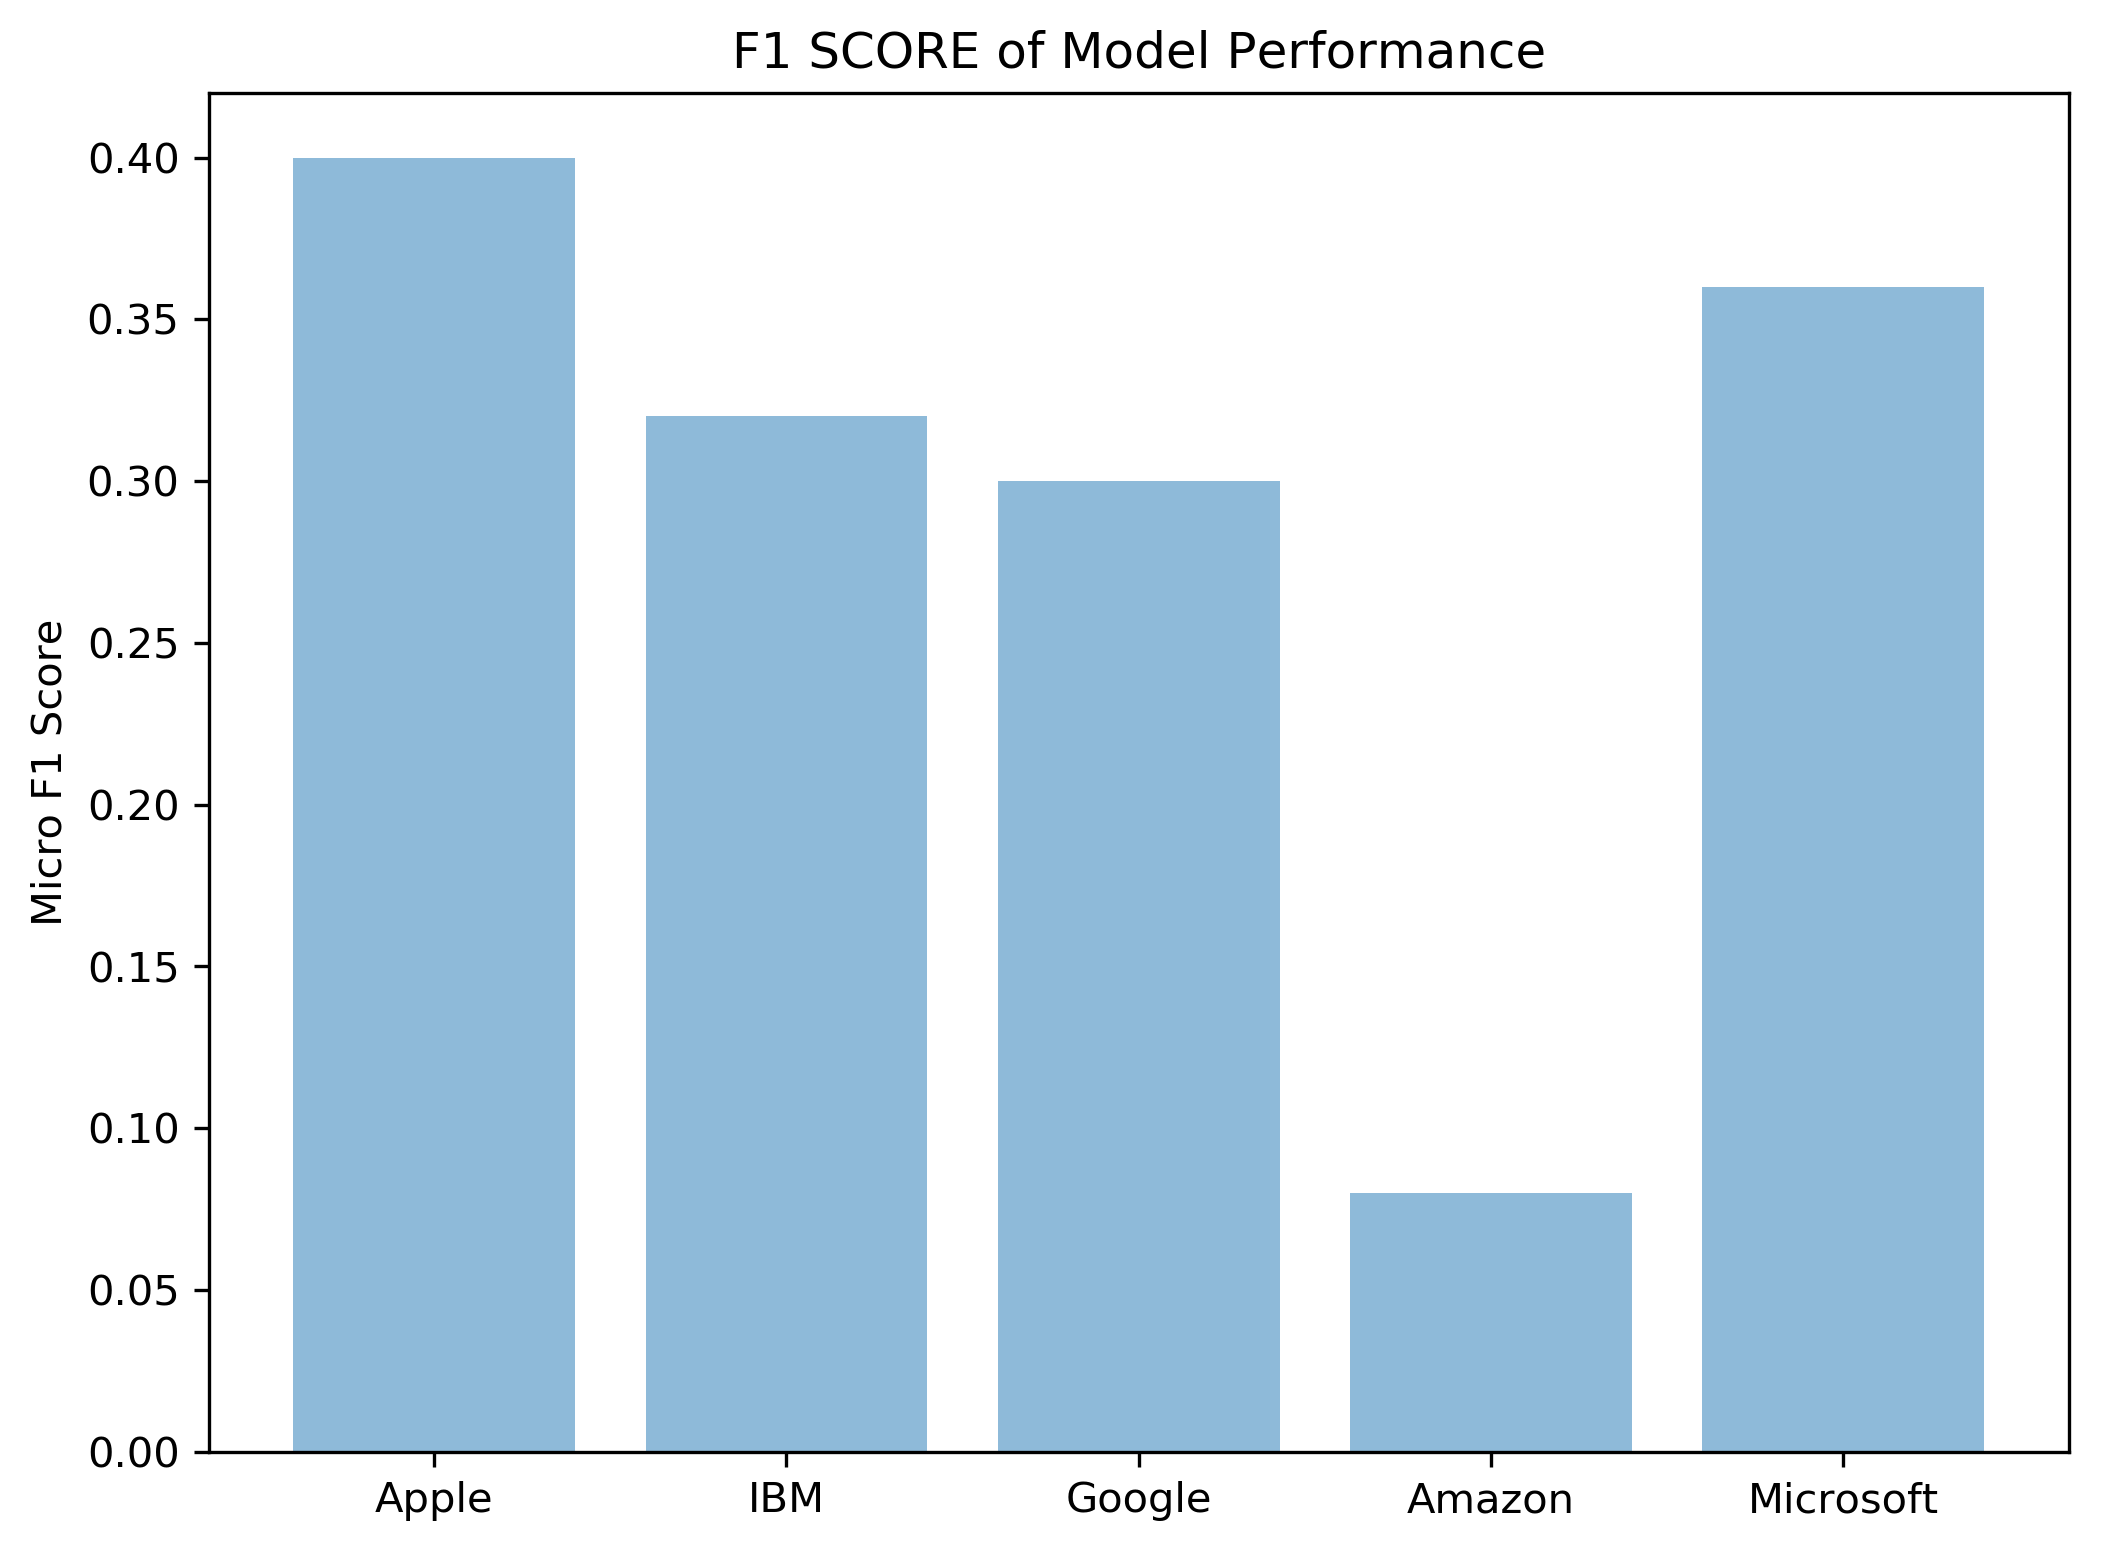

In [61]:
%notebook inline
f1 = [0.4, .32, .30, .08, .36]
import seaborn as sns
sns.set_style()
objects = ('Apple', 'IBM', 'Google', 'Amazon', 'Microsoft')
y_pos = np.arange(len(objects))

plt.figure(figsize=(8,6),dpi=300)
plt.bar(y_pos, f1, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Micro F1 Score')
plt.title('F1 SCORE of Model Performance')
 
plt.show()